# Root cause analysis (RCA) of latencies in a microservice architecture

In this case study, we identify the root causes of "unexpected" observed latencies in cloud services that empower an
online shop. We focus on the process of placing an order, which involves different services to make sure that
the placed order is valid, the customer is authenticated, the shipping costs are calculated correctly, and the shipping
process is initiated accordingly. The dependencies of the services is shown in the graph below.

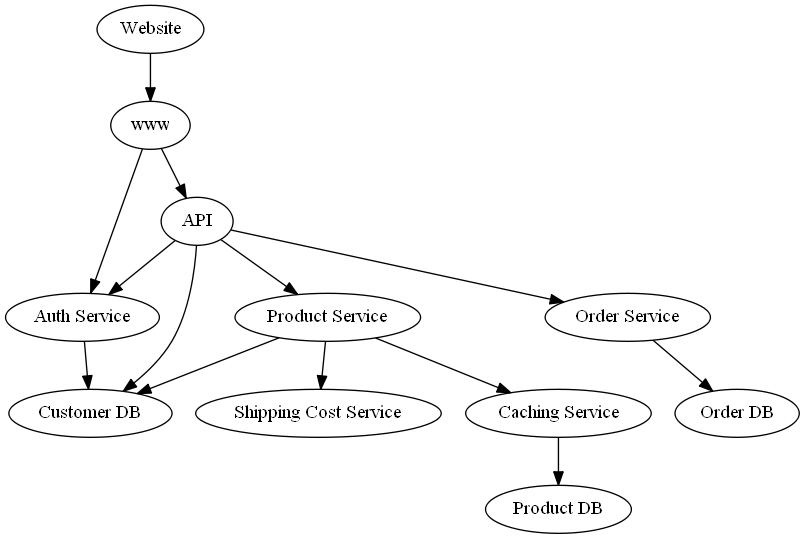

In [1]:
from IPython.display import Image
Image('microservice-architecture-dependencies.png', width=500) 

This kind of dependency graph could be obtained from services like [Amazon X-Ray](https://aws.amazon.com/xray/) or
defined manually based on the trace structure of requests.

We assume that the dependency graph above is correct and that we are able to measure the latency (in seconds) of each node for an order request. In case of `Website`, the latency would represent the time until a confirmation of the order is shown. For simplicity, let us assume that the services are synchronized, i.e., a service has to wait for downstream services in order to proceed. Further, we assume that two nodes are not impacted by unobserved factors (hidden confounders) at the same time (i.e., causal sufficiency). Seeing that, for instance, network traffic affects multiple services, this assumption might be typically violated in a real-world scenario. However, weak confounders can be neglected, while stronger ones (like network traffic) could falsely render multiple nodes as root causes. Generally, we can only identify causes that are part of the data.

Under these assumptions, the observed latency of a node is defined by the latency of the node itself (intrinsic latency), and the sum over all latencies of direct child nodes. This could also include calling a child node multiple times.

Let us load data with observed latencies of each node.

In [2]:
import pandas as pd

normal_data = pd.read_csv("rca_microservice_architecture_latencies.csv")
normal_data.head()

,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0.553608,0.057729,0.153977,0.120217,0.122195,0.391738,0.399664,0.710525,2.103962,2.580403,2.971071
1,0.053393,0.239560,0.297794,0.142854,0.275471,0.545372,0.646370,0.991620,2.932192,3.804571,3.895535
2,0.023860,0.300044,0.042169,0.125017,0.152685,0.574918,0.672228,0.964807,3.106218,4.076227,4.441924
3,0.118598,0.478097,0.042383,0.143969,0.222720,0.618129,0.638179,0.938366,3.217643,4.043560,4.334924
4,0.524901,0.078031,0.031694,0.231884,0.647452,1.081753,0.388506,0.711937,2.793605,3.215307,3.255062


In the matrix above, the plots on the diagonal line are histograms of variables, whereas those outside of the diagonal are scatter plots of pair of variables. The histograms of services without a dependency, namely `Customer DB`, `Product DB`, `Order DB` and `Shipping Cost Service`, have shapes similar to one half of a Gaussian distribution. The scatter plots of various pairs of variables (e.g., `API` and `www`, `www` and `Website`, `Order Service` and `Order DB`) show linear relations. We shall use this information shortly to assign generative causal models to nodes in the causal graph.

## Setting up the causal graph

If we look at the `Website` node, it becomes apparent that the latency we experience there depends on the latencies of
all downstream nodes. In particular, if one of the downstream nodes takes a long time, `Website` will also take a
long time to show an update. Seeing this, the causal graph of the latencies can be built by inverting the arrows of the
service graph.

In [3]:
import networkx as nx
from dowhy import gcm

causal_graph = nx.DiGraph([('www', 'Website'),
                           ('Auth Service', 'www'),
                           ('API', 'www'),
                           ('Customer DB', 'Auth Service'),
                           ('Customer DB', 'API'),
                           ('Product Service', 'API'),
                           ('Auth Service', 'API'),
                           ('Order Service', 'API'),
                           ('Shipping Cost Service', 'Product Service'),
                           ('Caching Service', 'Product Service'),
                           ('Product DB', 'Caching Service'),
                           ('Customer DB', 'Product Service'),
                           ('Order DB', 'Order Service')])

In [4]:
for node in causal_graph.nodes:
    print(node)
    print(tuple(sorted(causal_graph.predecessors(node))))

www
('API', 'Auth Service')
Website
('www',)
Auth Service
('Customer DB',)
API
('Auth Service', 'Customer DB', 'Order Service', 'Product Service')
Customer DB
()
Product Service
('Caching Service', 'Customer DB', 'Shipping Cost Service')
Order Service
('Order DB',)
Shipping Cost Service
()
Caching Service
('Product DB',)
Product DB
()
Order DB
()


In [5]:
#gcm.util.plot(causal_graph, figure_size=[13, 13])

TypeError: _plot_causal_graph_networkx() got an unexpected keyword argument 'figure_size'

In [ ]:
causal_graph.nodes

<div class="alert alert-block alert-info">
Here, we are interested in the causal relationships between latencies of services rather than the order of calling the services.
</div>

We will use the information from the pair-wise scatter plots and histograms to manually assign causal models. In particular, we assign half-Normal distributions to the root nodes (i.e., `Customer DB`, `Product DB`, `Order DB` and `Shipping Cost Service`). For non-root nodes, we assign linear additive noise models (which scatter plots of many parent-child pairs indicate) with empirical distribution of noise terms.

In [ ]:
from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

for node in causal_graph.nodes:
    if len(list(causal_graph.predecessors(node))) > 0: 
        causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    else:
        ### when the node has no parent
        causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm))

<div class="alert alert-block alert-info">
Alternatively, we can also automate this **if** we don't have prior knowledge or are not familiar with the statistical implications:
    
> gcm.auto.assign_causal_mechanisms(causal_model, normal_data)
</div>

In [ ]:
causal_model.graph.nodes

In [ ]:
for node in causal_graph.nodes:
    print(f"causal mechanism at node [{node}] = {causal_model.graph.nodes[node]}")

## Scenario 1: Observing a single outlier

Suppose we get an alert from our system where a customer experienced an unusually high latency when
an order is placed. Our task is now to investigate this issue and to find the root cause of this behaviour.

We first load the latency to the corresponding alert.

In [ ]:
outlier_data = pd.read_csv("rca_microservice_architecture_anomaly.csv")
outlier_data

We are interested in the increased latency of `Website` which the customer directly experienced.

In [ ]:
outlier_data.iloc[0]['Website']-normal_data['Website'].mean()

For this customer, `Website` was roughly 2 seconds slower than for other customers on average. Why?

### Attributing an outlier latency at a target service to other services

To answer why `Website` was slower for this customer, we attribute the outlier latency at `Website` to upstream services in the causal graph. We refer the reader to [Janzing et al., 2019](https://arxiv.org/abs/1912.02724) for scientific details behind this API. We will calculate a 95% bootstrapped confidence interval of our attributions. In particular, we learn the causal models from a random subset of normal data and attribute the target outlier score using those models, repeating the process 10 times. This way, the confidence intervals we report account for (a) the uncertainty of our causal models as well as (b) the uncertainty in the attributions due to the variance in the samples drawn from those causal models.

In [ ]:
gcm.config.disable_progress_bars() # to disable print statements when computing Shapley valuesΩ
median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    gcm.bootstrap_training_and_sampling(gcm.attribute_anomalies,
                                        causal_model,
                                        normal_data,
                                        target_node='Website',
                                        anomaly_samples=outlier_data),
    num_bootstrap_resamples=1)

<div class="alert alert-block alert-info">
By default, a quantile-based anomaly score is used that estimates the negative log-probability of a sample being
normal. This is, the higher the probabilty of an outlier, the larger the score. The library offers different kinds of outlier scoring functions, such as the <a href="https://en.wikipedia.org/wiki/Standard_score">z-score</a>, where the mean is the expected value based on the causal model.</div>

Let us visualize the attributions along with their uncertainty in a bar plot.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def bar_plot_with_uncertainty(median_attribs, uncertainty_attribs, ylabel='Attribution Score', figsize=(8, 3), bwidth=0.8, xticks=None, xticks_rotation=90):
    fig, ax = plt.subplots(figsize=figsize)
    yerr_plus = [uncertainty_attribs[node][1] - median_attribs[node] for node in median_attribs.keys()]
    yerr_minus = [median_attribs[node] - uncertainty_attribs[node][0] for node in median_attribs.keys()]
    plt.bar(median_attribs.keys(), median_attribs.values(), yerr=np.array([yerr_minus, yerr_plus]), ecolor='#1E88E5', color='#ff0d57', width=bwidth)
    plt.xticks(rotation=xticks_rotation)
    plt.ylabel(ylabel)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if xticks:
        plt.xticks(list(median_attribs.keys()), xticks)
    plt.show()

bar_plot_with_uncertainty(median_attribs, uncertainty_attribs)

The attributions indicate that `Caching Service` is the main driver of high latency in `Website` which is expected as we perturb the causal mechanism of `Caching Service` to generate an outlier latency in `Website` (see Appendix below). Attributions to `Customer DB` and `Product Service` can be explained by misspecification of causal models. First, some of the parent-child relationships in the causal graph are non-linear (by looking at the scatter matrix). Second, the parent child-relationship between `Caching Service` and `Product DB` seems to indicate two mechanisms. This could be due to an unobserved binary variable (e.g., Cache hit/miss) that has a multiplicative effect on `Caching Service`. An additive noise cannot capture the multiplicative effect of this unobserved variable.